Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis

###Importing Skin Cancer Data

Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing.**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### **Create a dataset**


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

AttributeError: ignored

Visualize the data

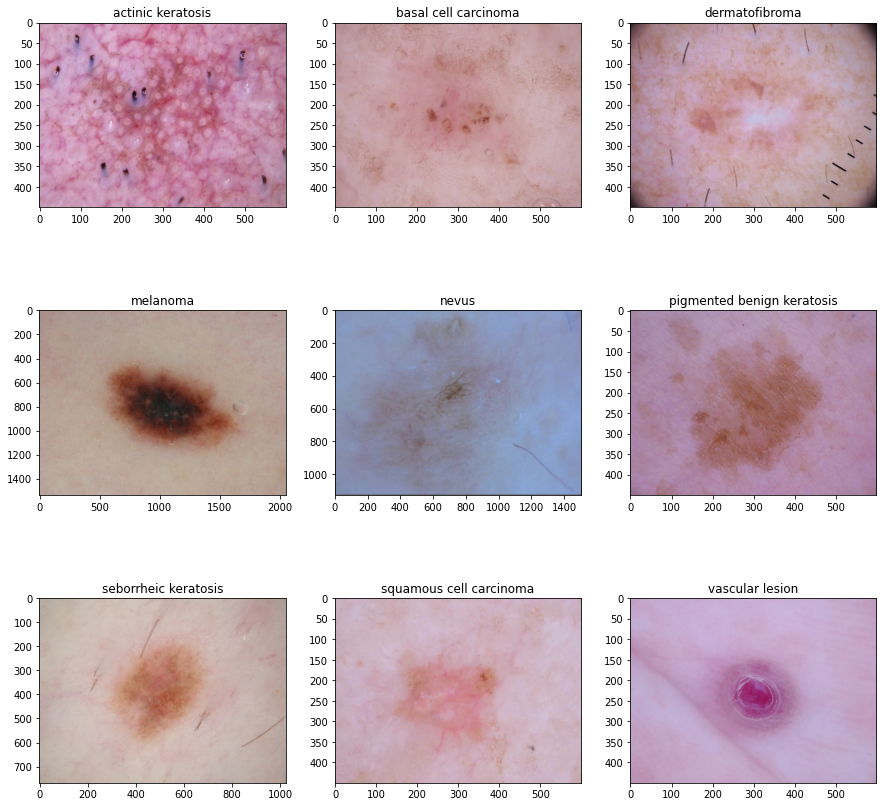

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 158s 799ms/step - loss: 2.0526 - accuracy: 0.1903 - val_loss: 2.0006 - val_accuracy: 0.2192
Epoch 2/20
56/56 [==============================] - 4s 76ms/step - loss: 1.9561 - accuracy: 0.2623 - val_loss: 1.8727 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 4s 76ms/step - loss: 1.8057 - accuracy: 0.3158 - val_loss: 1.7233 - val_accuracy: 0.3624
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 1.7345 - accuracy: 0.3555 - val_loss: 1.7222 - val_accuracy: 0.3512
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.6617 - accuracy: 0.3912 - val_loss: 1.6249 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5630 - accuracy: 0.4235 - val_loss: 1.5717 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5035 - accuracy: 0.4593 - val_loss: 1.5306 - val_accuracy: 0.4586
Epoch 8/20
56/56 [===

Visualizing the results

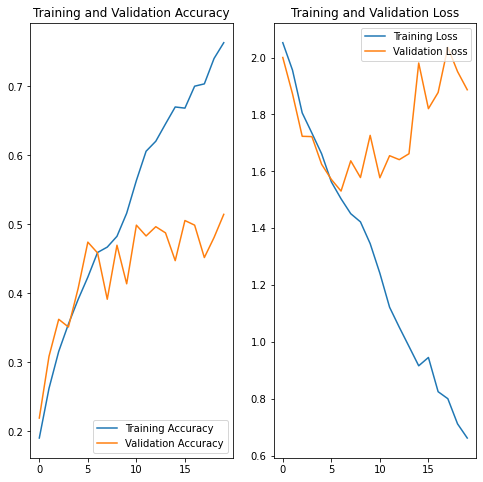

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Finding on the first base model

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

The accuracy is just around 75-80% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting debate

In [ ]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

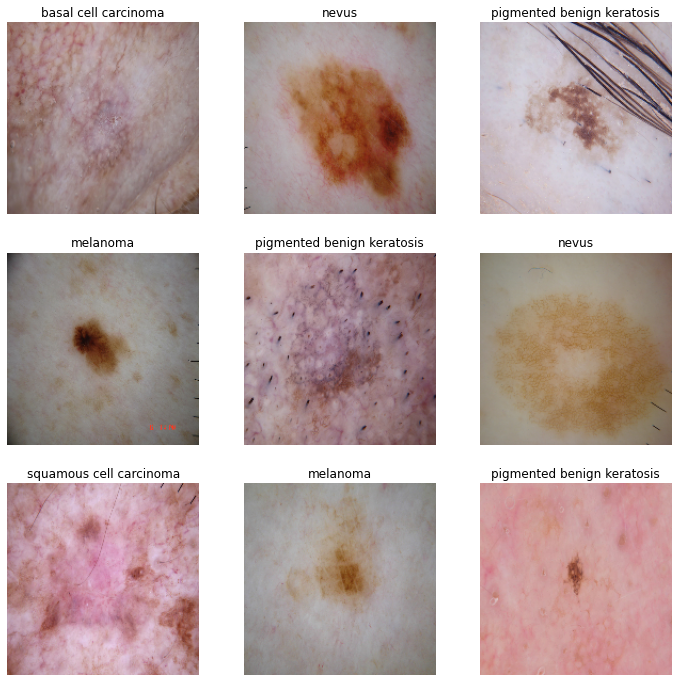

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Create the model, compile and train the model

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 95ms/step - loss: 2.0237 - accuracy: 0.2316 - val_loss: 1.8063 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 5s 87ms/step - loss: 1.7582 - accuracy: 0.3638 - val_loss: 1.6925 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6577 - accuracy: 0.4057 - val_loss: 1.6829 - val_accuracy: 0.3893
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6234 - accuracy: 0.4235 - val_loss: 1.6441 - val_accuracy: 0.4228
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6313 - accuracy: 0.4252 - val_loss: 1.5839 - val_accuracy: 0.4452
Epoch 6/20
56/56 [==============================] - 5s 86ms/step - loss: 1.5772 - accuracy: 0.4336 - val_loss: 1.5765 - val_accuracy: 0.4541
Epoch 7/20
56/56 [==============================] - 5s 86ms/step - loss: 1.5575 - accuracy: 0.4470 - val_loss: 1.5515 - val_accuracy: 0.4519
Epoch 8/20
56

Visualizing the results

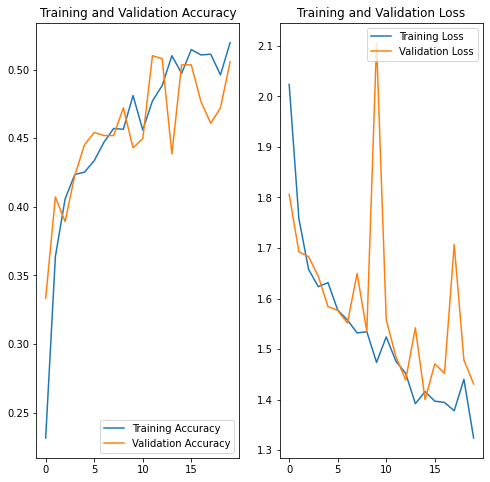

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


Finding from Second Model

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

In [ ]:
##
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2235,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2236,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2237,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion


In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2235,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2236,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2237,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion


<BarContainer object of 9 artists>

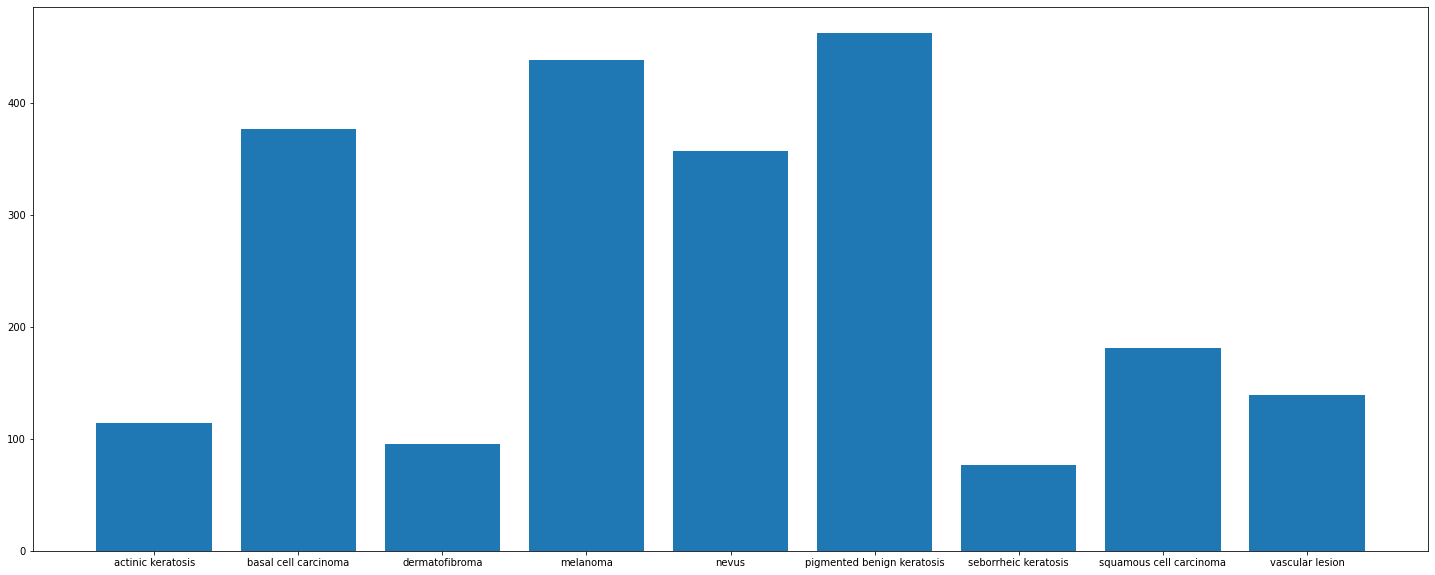

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

Write your findings here:
Which class has the least number of samples?

Sol:  Squamous cell carcinoma holds the least number of samples.

Which classes dominate the data in terms proportionate number of samples?

Sol: Actinic keratosis and dermatofibroma and melanoma and pigmented benign keratosis have proprtionate number of classes.



In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDEA63733D0>: 100%|██████████| 500/500 [00:42<00:00, 11.78 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF104AA390>: 100%|██████████| 500/500 [00:45<00:00, 11.10 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDEA6113D50>: 100%|██████████| 500/500 [00:42<00:00, 11.75 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDEA6373CD0>: 100%|██████████| 500/500 [00:47<00:00, 10.45 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDEA638CE90>: 100%|██████████| 500/500 [00:44<00:00, 11.20 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FDE8F76A390>: 100%|██████████| 500/500 [00:43<00:00, 11.46 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDF10526910>: 100%|██████████| 500/500 [00:42<00:00, 11.63 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDF104EB890>: 100%|██████████| 500/500 [00:42<00:00, 11.64 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDEA63EC490>: 100%|██████████| 500/500 [00:41<00:00, 12.04 Samples/s]


In [ ]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [ ]:
##
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Melano...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2235,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2236,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion
2237,/content/gdrive/MyDrive/Colab Notebooks/Melano...,vascular lesion


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
import pathlib
#data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train")

In [ ]:
data_dir_train1

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [ ]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment /Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


Create your model (make sure to include normalization)

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile your model (Choose optimizer and loss function appropriately)


In [ ]:
## ### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train your model

In [ ]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 37s 210ms/step - loss: nan - accuracy: 0.0191 - val_loss: nan - val_accuracy: 0.0230
Epoch 2/50
169/169 [==============================] - 35s 198ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 3/50
169/169 [==============================] - 35s 201ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 4/50
169/169 [==============================] - 36s 205ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 5/50
169/169 [==============================] - 36s 208ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 6/50
169/169 [==============================] - 35s 200ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 7/50
169/169 [==============================] - 35s 198ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 8/50
169/169 [==================

Visualize the model results

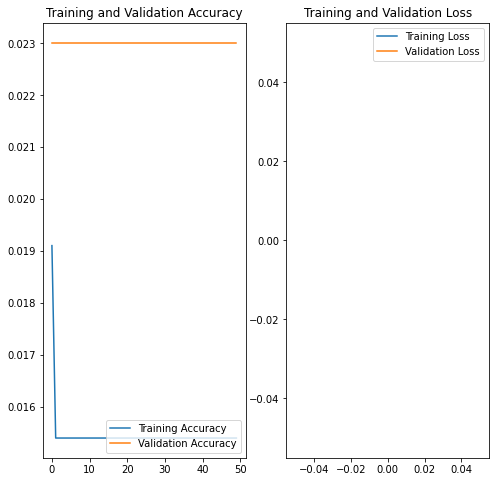

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Accuracy on training data has increased by using Augmentor library

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.